# Lab: Explainability in Neural Networks with activation maximization.


------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------

**Team Members**:
- Felipe Guzmán Rodríguez: 100535519@alumnos.uc3m.es
- Álvaro Alcalde Cid: 100428760@alumnos.uc3m.es
- Rubén Ribes Serrano: 100537798@alumnos.uc3m.es

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [19]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [20]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [21]:
dataiter = iter(trainloader)   # To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's show some image from that batch ...

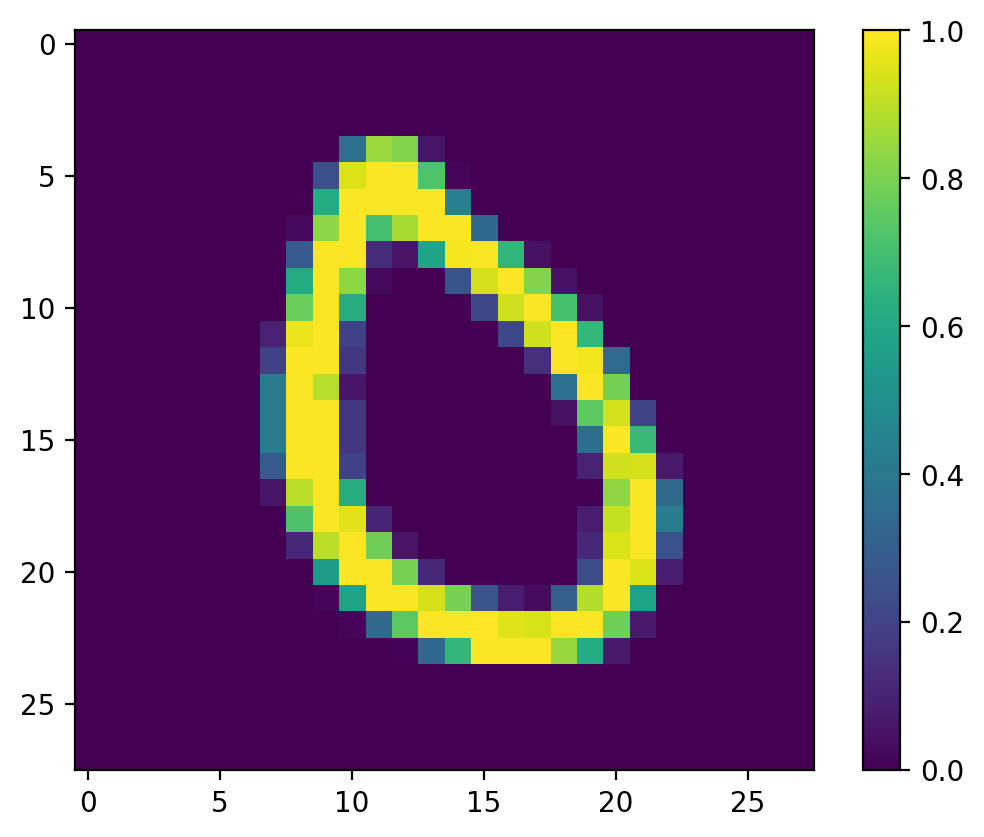

In [22]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

We also create a validation set.

In [23]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [24]:
#YOUR CODE HERE
class MLPdrop(nn.Module):
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, dropout=0.2):
        super().__init__()
        
        self.output1 = nn.Linear(dimx, hidden1)
        
        self.output2 = nn.Linear(hidden1, hidden2)
        
        self.output3 = nn.Linear(hidden2, hidden3)
        
        self.output4 = nn.Linear(hidden3, nlabels)
        
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
            x = self.output1(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.output2(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.output3(x)
            x = self.relu(x)
            x = self.dropout(x)
            
            x = self.output4(x)
            x = self.logsoftmax(x)
            
            return x

In [25]:
class MLPdrop_extended(MLPdrop):
    #YOUR CODE HERE
    def __init__(self, dimx, hidden1, hidden2, hidden3, nlabels, epochs=100, lr=0.001, dropout=0.2):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels, dropout=dropout)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = [] 

    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            running_loss = 0
            self.train()
            
            for images, labels in trainloader:
                self.optim.zero_grad()
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))
            
            valid_loss = 0 
            with torch.no_grad():
                self.eval()  
                
                for images, labels in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()
            self.valid_loss_during_training.append(valid_loss / len(validloader))

            print(f"Epoch {e + 1}/{self.epochs}.. "
                  f"Training loss: {self.loss_during_training[-1]:.3f}.. "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f}")

    def evaluate(self, dataloader):
        accuracy = 0
        
        with torch.no_grad():
            self.eval()  
            
            for images, labels in dataloader:
                logprobs = self.forward(images.view(images.shape[0], -1))
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        return accuracy / len(dataloader)

Epoch 1/3.. Training loss: 0.446.. Validation loss: 0.172
Epoch 2/3.. Training loss: 0.177.. Validation loss: 0.141
Epoch 3/3.. Training loss: 0.129.. Validation loss: 0.116
Train Evaluation: 0.9767, Test Evaluation: 0.9677, Validation Evaluation: 0.9644


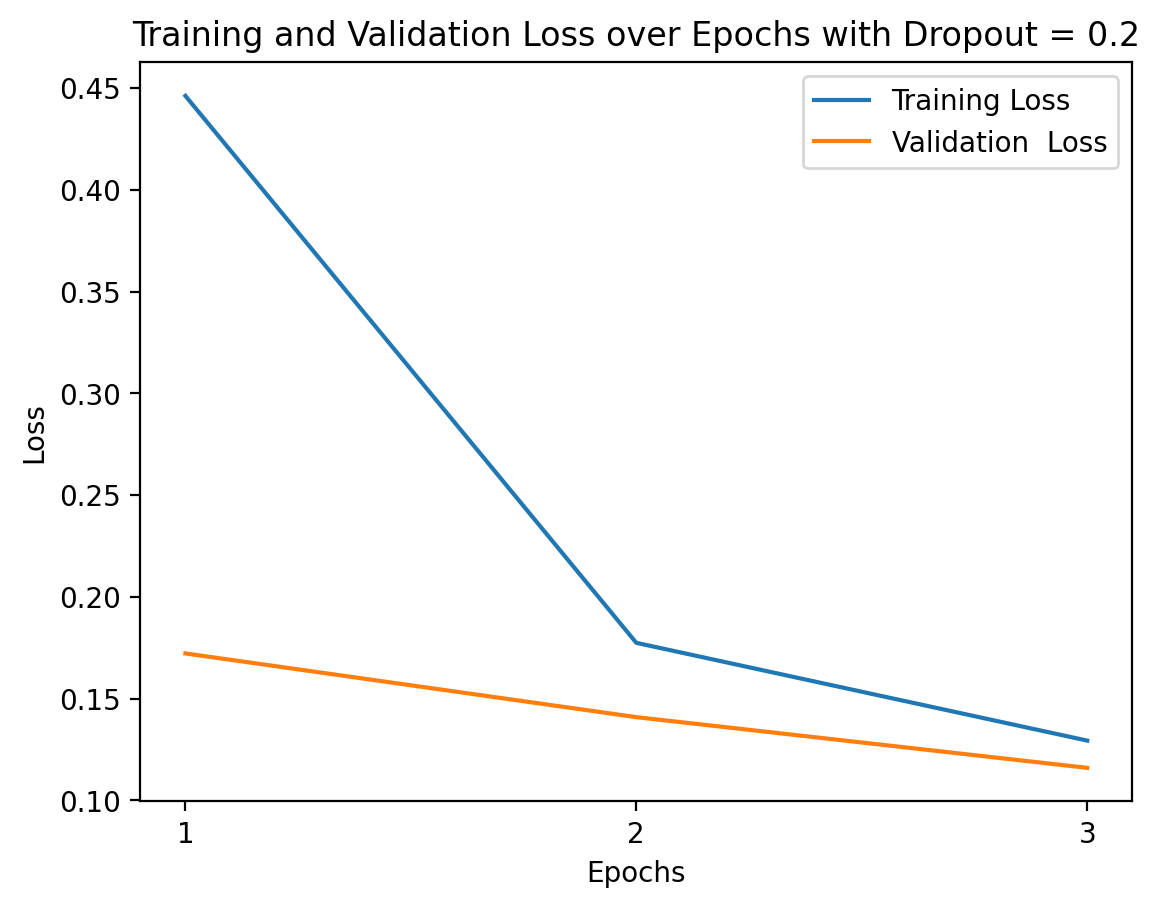

In [26]:
#YOUR CODE HERE
my_MLP_drop = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=3, lr=1e-3, dropout=0.2)
my_MLP_drop.trainloop(trainloader, validloader)

train_accuracy = my_MLP_drop.evaluate(trainloader)
test_accuracy = my_MLP_drop.evaluate(testloader)
valid_accuracy = my_MLP_drop.evaluate(validloader)

print(f"Train Evaluation: {train_accuracy:.4f}, Test Evaluation: {test_accuracy:.4f}, Validation Evaluation: {valid_accuracy:.4f}")

epochs = len(my_MLP_drop.loss_during_training)
x_values = np.arange(1, epochs + 1)
plt.plot(x_values, my_MLP_drop.loss_during_training, label="Training Loss")
plt.plot(x_values, my_MLP_drop.valid_loss_during_training, label="Validation  Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss over Epochs with Dropout = 0.2")
plt.xticks(x_values)
plt.legend()
plt.show()


**Mechanisms applied**: As we learnt at the previous labs, at the previous neural net, we applied the dropout technique with different values and we considered that with a dropout value of 0.2, we obtain a great performance of the net.

## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

In [27]:
for param in my_MLP_drop.parameters(): #my_MLP_drop is the name of your neural network!
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [28]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 

        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0.reshape([1,-1]),requires_grad = True)
        
        self.img0 = img0

        self.NN_trained = NN_trained

        self.lr = lr
        
        # We use mean squared error to minimize the difference between the desired probability and the 
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        logprobs = self.NN_trained(self.input.view(1, -1))
        
        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(true_prob)

        # sgd_iter is the number of iterations
        
        for i in range(sgd_iter):

            # Reset the gradients
            #YOUR CODE HERE 
            self.optim.zero_grad()
            
            # Compute the network output
            #YOUR CODE HERE
            logprobs = self.forward()
            
            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            loss = self.criterion(logprobs[0,category].view(true_log_prob.shape), true_log_prob)

            self.loss_during_training.append(loss)

            # Compute gradients
            #YOUR CODE HERE
            loss.backward()
            
            # Optimize
            #YOUR CODE HERE
            self.optim.step()

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [29]:
opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

**ANSWER**: The result shows that with a random input, the network isn’t very confident about which digit it is seeing. It assigns varying probabilities to multiple digits, with one digit having the highest probability. However, this probability is still low, and the network spreads the confidence across other digits. This occurs because the input is random noise, not a recognizable digit, so the network is uncertain and distributes the probabilities among different possible classes.

In [30]:
#YOUR CODE HERE
logprobs_before = opt_input.forward()
logprobs_before = torch.exp(logprobs_before)
print(logprobs_before)

for i, prob_before in enumerate(logprobs_before[0]):
    print(f"Probability of being digit {i}: {prob_before.item():.4f}")


tensor([[0.0573, 0.0787, 0.0498, 0.0756, 0.0964, 0.2808, 0.1303, 0.0790, 0.0862,
         0.0658]], grad_fn=<ExpBackward0>)
Probability of being digit 0: 0.0573
Probability of being digit 1: 0.0787
Probability of being digit 2: 0.0498
Probability of being digit 3: 0.0756
Probability of being digit 4: 0.0964
Probability of being digit 5: 0.2808
Probability of being digit 6: 0.1303
Probability of being digit 7: 0.0790
Probability of being digit 8: 0.0862
Probability of being digit 9: 0.0658


> **Exercise**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

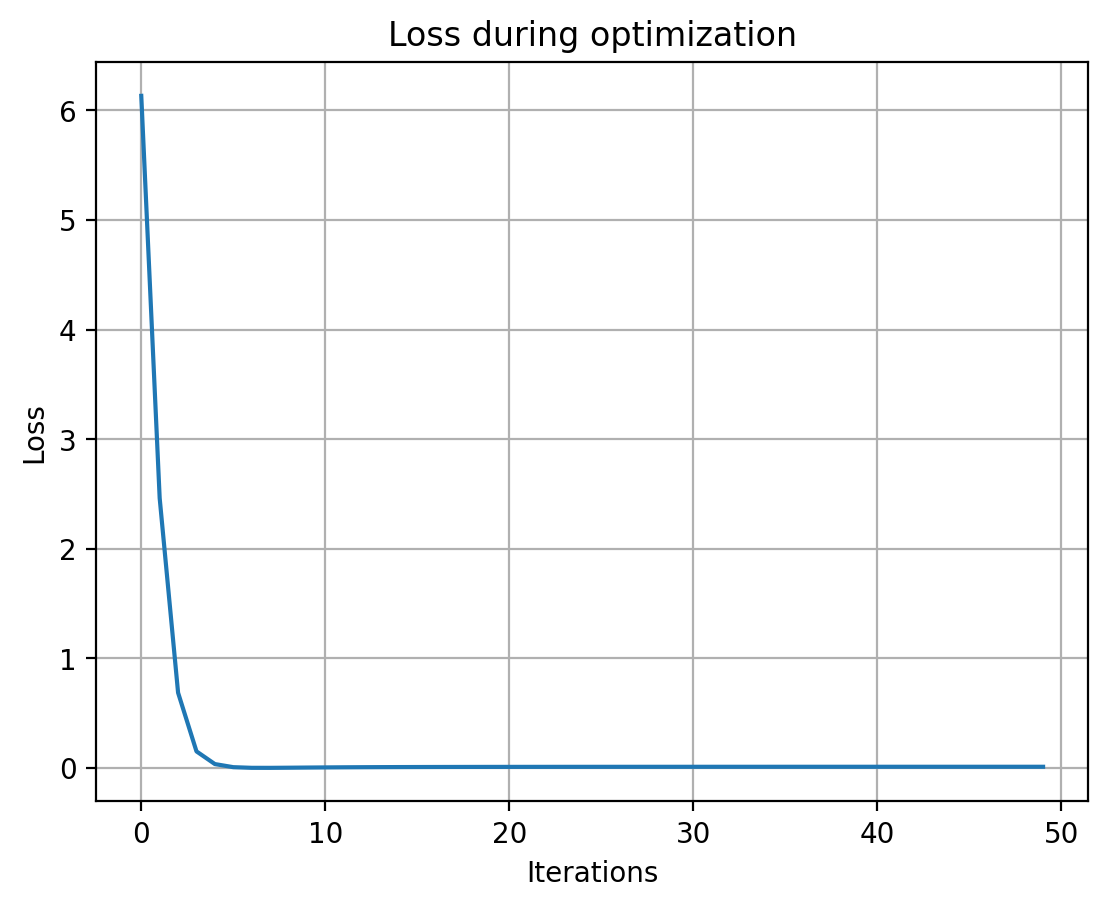

Probability of being digit 3: 0.9953


In [31]:
#YOUR CODE HERE
category = 3
true_prob = torch.tensor(0.9)
sgd_iter = 50
opt_input.trainloop(category, true_prob, sgd_iter)

log_probs = opt_input.forward()
probs = torch.exp(log_probs)

# Graficamos la función de pérdida
plt.plot([loss.item() for loss in opt_input.loss_during_training])
plt.title('Loss during optimization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

print(f"Probability of being digit 3: {probs[0, 3].item():.4f}")

> **Exercise:** Compare the probabilities at the output of the classifier before and after optimizing at the input

In [32]:
#YOUR CODE HERE
logprobs_after = opt_input.forward()
logprobs_after = torch.exp(logprobs_after)
print(logprobs_after)

print("\nComparison of probabilities:")
for i in range(10):  # Iterate over each digit class (0-9)
    print(f"Digit {i}: Before: {logprobs_before[0][i].item()}, After: {logprobs_after[0][i].item()}")

tensor([[2.7186e-06, 3.1219e-04, 9.9915e-04, 9.9528e-01, 5.0239e-06, 1.4805e-03,
         6.8124e-08, 1.3366e-03, 5.1091e-04, 7.4391e-05]],
       grad_fn=<ExpBackward0>)

Comparison of probabilities:
Digit 0: Before: 0.057278405874967575, After: 2.718597443163162e-06
Digit 1: Before: 0.07871439307928085, After: 0.0003121885529253632
Digit 2: Before: 0.049829959869384766, After: 0.0009991467231884599
Digit 3: Before: 0.07564786821603775, After: 0.9952785968780518
Digit 4: Before: 0.09636841714382172, After: 5.023850008001318e-06
Digit 5: Before: 0.2808002233505249, After: 0.0014804573729634285
Digit 6: Before: 0.13027988374233246, After: 6.81244074485221e-08
Digit 7: Before: 0.07900536805391312, After: 0.001336568733677268
Digit 8: Before: 0.08623017370700836, After: 0.0005109093035571277
Digit 9: Before: 0.06584526598453522, After: 7.439075852744281e-05


> **Exercise:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

**ANSWER**:The output doesn’t exactly resemble the number 3, although it’s still recognizable as a 3. These results could be improved by increasing the number of training epochs.

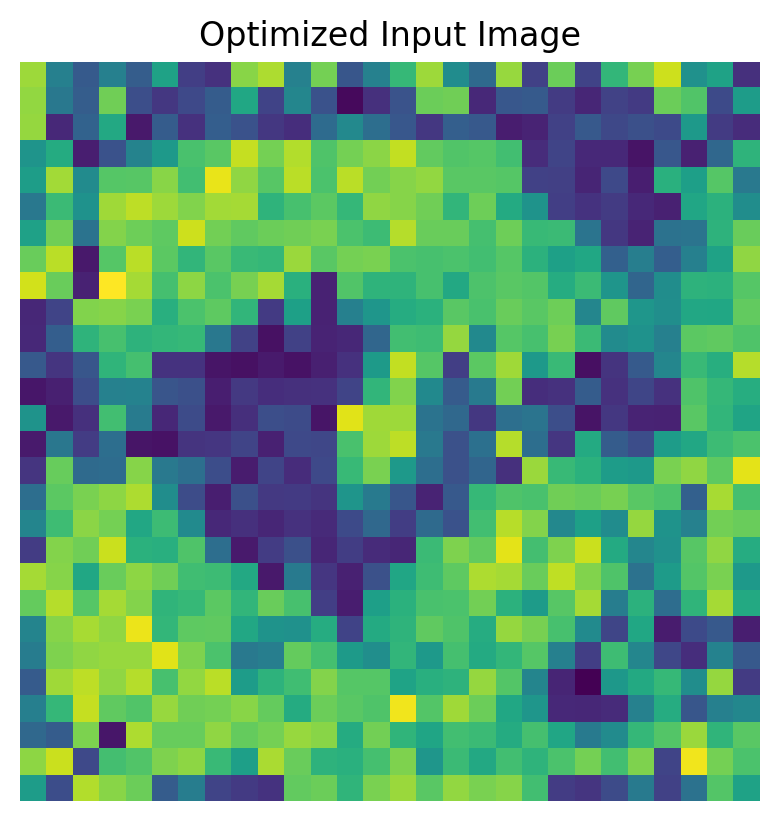

In [33]:
#YOUR CODE HERE
optimized_image = opt_input.input.detach().reshape(28, 28).cpu().numpy()

plt.figure()
plt.imshow(optimized_image)
plt.title('Optimized Input Image')
plt.axis('off')
plt.show()

> ⁠**Exercise:** Repeat the results for all digits and discuss those results.

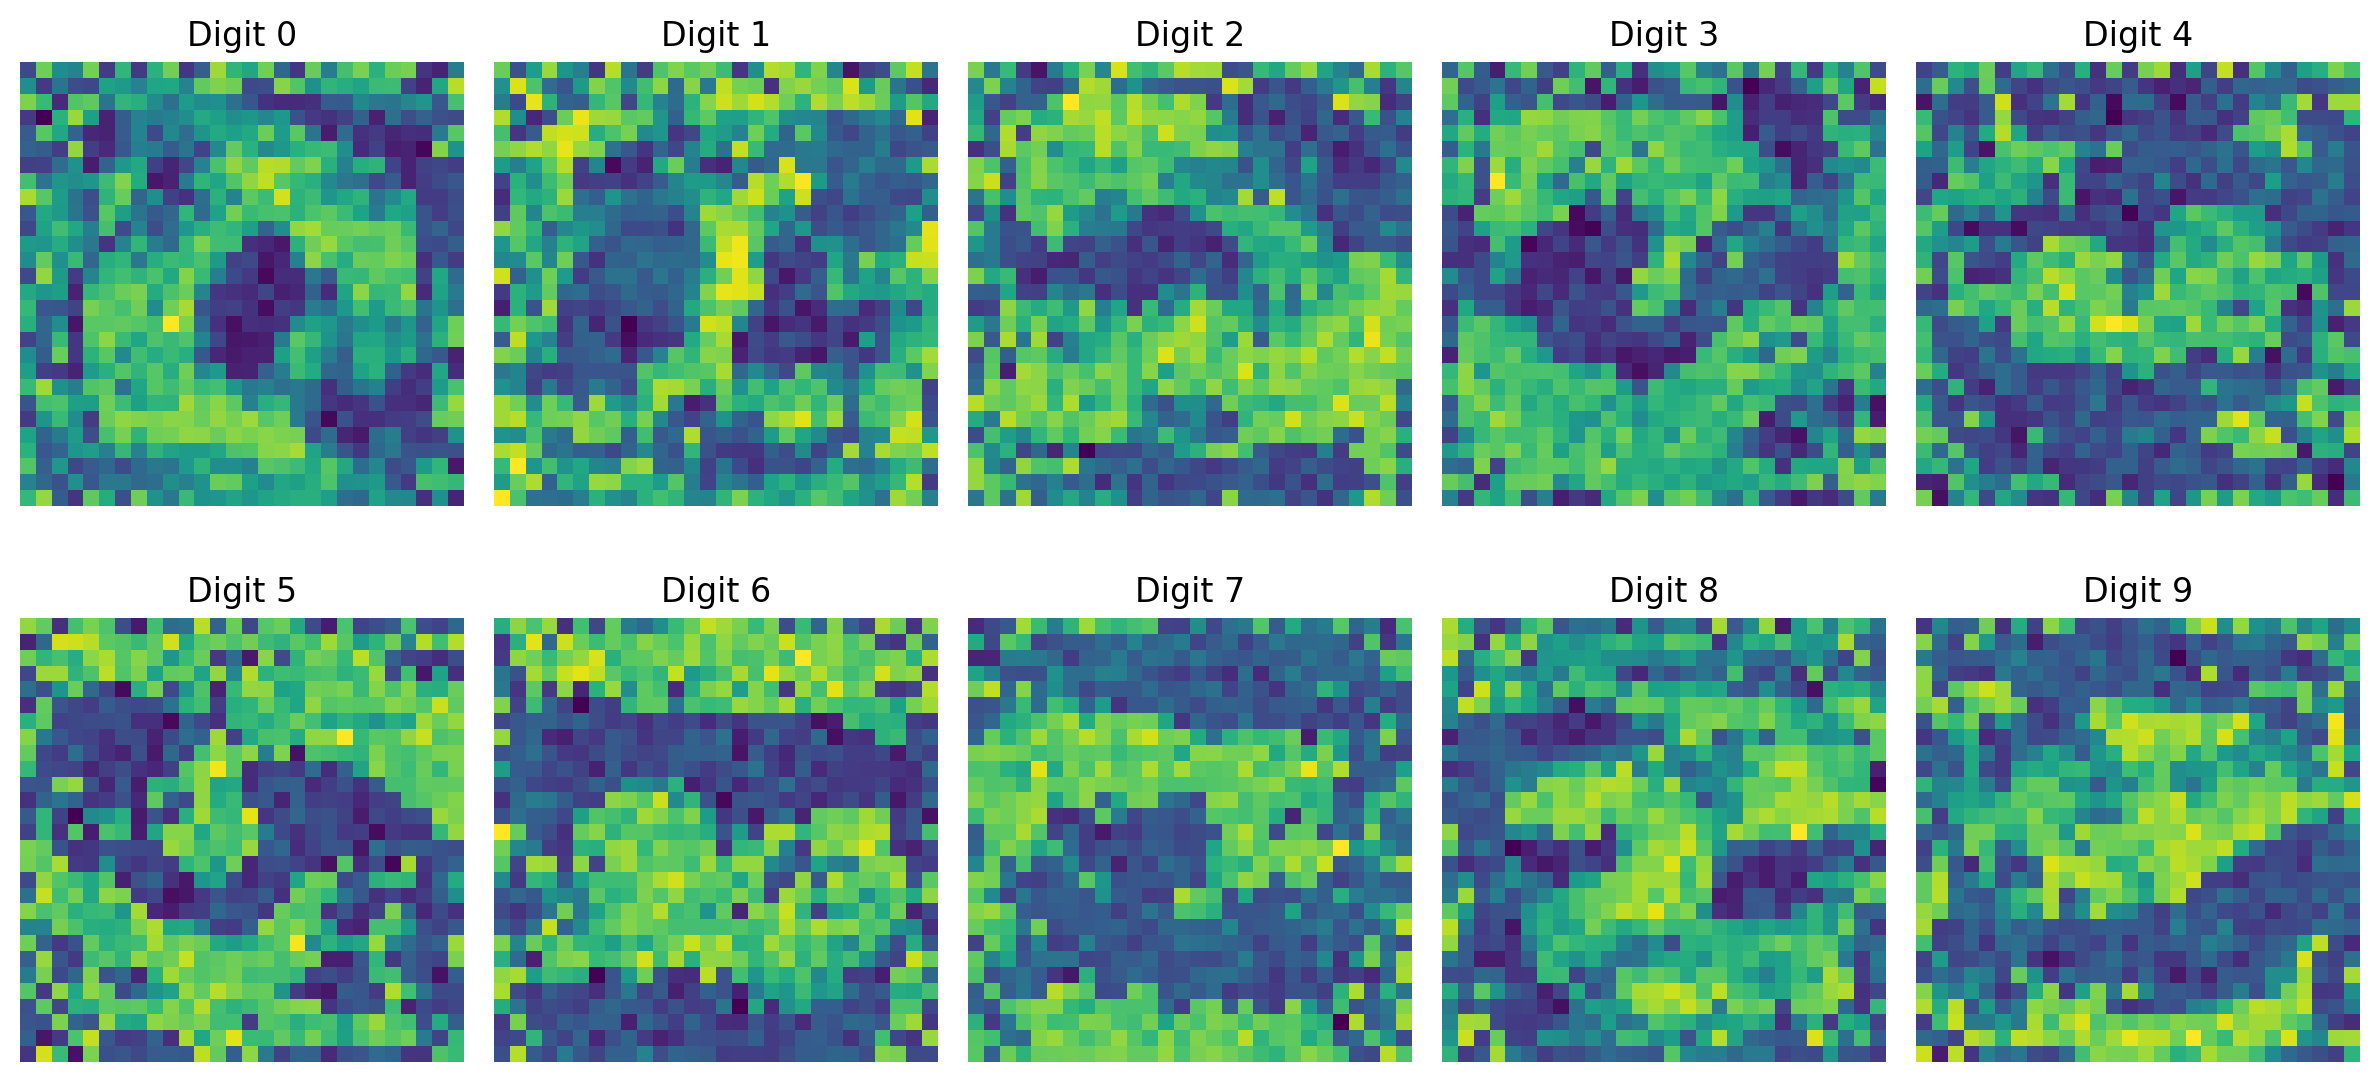

In [34]:
#YOUR CODE HERE
true_prob = torch.tensor(0.9)
sgd_iter = 50

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for digit in range(10):

    opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop, lr=5e-3, img0=torch.randn(28,28)*0.01)

    opt_input.trainloop(category=digit, true_prob=true_prob, sgd_iter=sgd_iter)

    optimized_image = opt_input.input.detach().cpu().numpy().reshape(28, 28)
    
    axes[digit].imshow(optimized_image)
    axes[digit].set_title(f'Digit {digit}')
    axes[digit].axis('off')

plt.tight_layout()
plt.show()


> Discuss the results.

The optimized images for each digit (0-9) show that the network has learned to recognize certain patterns for each class, as the general shapes of some digits (like "0") are distinguishable. However, many of the images still appear noisy. This noise reflects the network’s varying ability to learn features for different digits, with some digits being clearer than others. 